In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim 

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
use_cuda = torch.cuda.is_available()

dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

# Preparing the data

In [3]:
imsize = 512 if use_cuda else 128

loader_transform = transforms.Compose([
    transforms.Scale(imsize),
    transforms.ToTensor()
])

# important notes for pytorch training

the PIL load image with values between 0 and 255. After being transformed to torch floatTensor,
the values are between 0 and 1.
neural networks from torch library are trained with 0-1 tensor image. Feeding images with values
between 0 and 255 makes no sense. While in Cafe the networks are pretrained with 0-255 tensor
images

In [4]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader_transform(image))
    
    image = image.unsqueeze(0) 
    # fake the batch dimension to fit the neural network input dimensions 
    return image

In [13]:
style_img = image_loader('picasso.jpg').type(dtype)
content_img = image_loader('dancing.jpg').type(dtype)

print(type(style_img))
print(style_img.requires_grad, style_img.)
assert style_img.size() == content_img.size(), \
'we need to import style and content images of the same size'

cloned_img = style_img.clone() * 2.0
print(type(cloned_img), cloned_img.requires_grad,cloned_img.volatile)


<class 'torch.autograd.variable.Variable'>
False
<class 'torch.autograd.variable.Variable'> False


# display the images

In [8]:
unloader_transform = transforms.ToPILImage()

#plt.ion()

def imshow(tensor, title = None):
    image = tensor.clone().cpu()
    image = image.squeeze(0) # an optinal operation image.view(3,imsize,imsize)
    #trnsform the image with values from 0-1 to 0-255 for (3, 128, 128) to (128, 128, 3)
    image = unloader_transform(image)
    #print(image.size)
    
    #image = image.numpy().transpose(1,2,0)
    #print(image.shape)
    plt.imshow(image)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

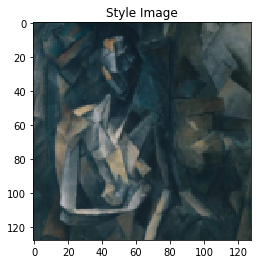

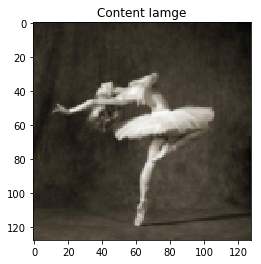

In [9]:
plt.figure()
imshow(style_img.data, title = 'Style Image')
plt.figure()
imshow(content_img.data, title = 'Content Iamge')

plt.show()

In [10]:
class ContentLoss(nn.Module):
    
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        self.target = target.clone() * weight
        print(type(self.target))
        self.weight = weight
        self.criterion = nn.MSELoss()
    
    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output
    def backward(self, retain_variables = True):
        self.loss.backward(retain_variables = retain_variables)
        return self.loss

In [11]:
class GramMatrix(nn.Module):
    def forward(self, input):
        a,b,c,d = input.size()
        
        features = input.view(a*b,c*d)
        
        G = torch.mm(features, features.t())
        
        return G.div(a * b * c * d)

In [11]:
class StyleLoss(nn.Module):
    
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.clone() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()
    
    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output
    def backward(self, retain_variables = True):
        self.loss.backward(retain_variables = retain_variables)
        return self.loss

In [12]:
cnn = models.vgg19(pretrained = True).features
if use_cuda:
    cnn = cnn.cuda()

print(list(cnn))

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU (inplace), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU (inplace), MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1)), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU (inplace), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU (inplace), MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1)), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU (inplace), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU (inplace), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU (inplace), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU (inplace), MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1)), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU (inplace), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 

In [13]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def build_model(cnn, style_img, content_img, 
                style_weight = 1000, content_weight = 1,
               content_layers = content_layers_default,
               style_layers = style_layers_default):
    cnn = copy.deepcopy(cnn)
    
    content_losses = []
    style_losses = []
    
    model = nn.Sequential()
    
    gram = GramMatrix()
    
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()
    
    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = 'conv_' + str(i)
            model.add_module(name, layer)
            
            if name in content_layers:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module('content_loss' + str(i), content_loss)
                content_losses.append(content_loss)
            
            if name in style_layers:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module('style_loss_' + str(i), style_loss)
                style_losses.append(style_loss)
                
        if isinstance(layer, nn.ReLU):
            name = 'relu_' + str(i)
            model.add_module(name, layer)
            
            if name in content_layers:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module('content_loss' + str(i), content_loss)
                content_losses.append(content_loss)
            
            if name in style_layers:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module('style_loss_' + str(i), style_loss)
                style_losses.append(style_loss)
            i += 1
        
        if isinstance(layer, nn.MaxPool2d):
            name = 'pool' + str(i)
            model.add_module(name, layer)
    
    return model, style_losses, content_losses
            

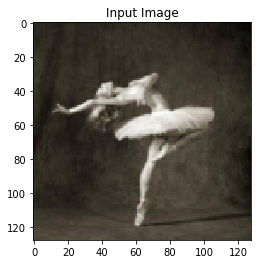

In [14]:
input_img = content_img.clone()
# input_img = Varaible(troch.randn(content_img.data.size())).type(dtype)

plt.figure()
imshow(input_img.data, title = 'Input Image')
plt.show()

In [15]:
def get_input_param_optimizer(input_img):
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

In [18]:
def run_transfer(cnn, content_img, style_img, input_img, num_steps = 300,
                style_weight = 1000, content_weight = 1):
    print('building style transfer model...')
    model, style_losses, content_losses = build_model(cnn, style_img,
                                                     content_img, style_weight,content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)
    
    print('Optimizing...')
    
    iteration = [0]
    while iteration[0] <= num_steps:
        
        def transfer_step():
            input_param.data.clamp_(0, 1)
            
            model(input_param)
            
            style_score = 0
            content_score = 0
            
            for style in style_losses:
                style_score += style.backward()
            for content in content_losses:
                content_score += content.backward()
            
            iteration[0] += 1
            print('style loss:{:4f} \n content loss:{:4f}'.format(
                style_score.data[0], content_score.data[0]))
            if iteration[0] % 50 == 0:
                print('run {}:'.format(iteration))
                print('style loss:{:4f} \n content loss:{:4f}'.format(
                style_score.data[0], content_score.data[0]))
                
            return style_score + content_score
        
        optimizer.zero_grad()
        optimizer.step(transfer_step)
    input_param.data.clamp_(0, 1)
    
    return input_param.data

In [ ]:
output = run_transfer(cnn, content_img, style_img, input_img)

plt.figure()
imshow(output, title = 'result')

plt.ioff()
plt.show()

building style transfer model...
Optimizing...
style loss:29897.613281 
 content loss:23.738916
style loss:29887.039062 
 content loss:23.736164
style loss:395112.812500 
 content loss:56.678356
style loss:786275.375000 
 content loss:69.831772
style loss:166103.406250 
 content loss:41.590851
style loss:88788.093750 
 content loss:34.093704
style loss:69319.820312 
 content loss:31.871244
style loss:57841.078125 
 content loss:29.988470
style loss:50545.246094 
 content loss:28.809538
style loss:46666.195312 
 content loss:28.384209
style loss:43465.824219 
 content loss:27.837255
style loss:40741.363281 
 content loss:27.094982
style loss:39290.117188 
 content loss:26.743509
style loss:37200.968750 
 content loss:26.369114
style loss:35183.539062 
 content loss:25.847359
style loss:35865.316406 
 content loss:25.931154
style loss:33573.867188 
 content loss:25.279051
style loss:33433.531250 
 content loss:25.398279
style loss:32990.394531 
 content loss:25.311600
style loss:32008.74